This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features

* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Imports

In [9]:
import os
import time
import sys
import gc
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
    
from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBRegressor
from xgboost import plot_importance


from fastai.tabular.core import add_datepart, TabularPandas, Categorify, FillMissing, TabDataLoader, cont_cat_split

sys.version_info

sys.version_info(major=3, minor=8, micro=0, releaselevel='final', serial=0)

# Utility Functions

In [10]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

# Config Jupyter

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load Data

In [12]:
# Do we need to specify data types for this dataset?
dtypes = {'id': 'int64', 'item_nbr': 'int32', 'onpromotion': 'object', 'store_nbr': 'int8', 'unit_sales': 'float32'}
date_columns = ['date']

## Notes
boolean need to be loaded as 'object' if there are nulls - we will convert below

In [13]:
project_name = 'Titanic'
nb_dir = os.path.abspath('')
feather_dir = os.path.join(nb_dir, '..', 'feather')
data_dir = r'/data/datasets/Titanic'
input_path = os.path.join(data_dir, 'titanic3.xls')
# train = pd.read_csv(os.path.join(data_dir, 'train.csv'), dtype=dtypes, parse_dates=date_columns)
train = pd.read_excel(input_path)

## Fix up data types

In [6]:
train.onpromotion.fillna(False, inplace=True)
train.onpromotion = train.onpromotion.map({'True': True, 'False': False})
train.onpromotion = train.onpromotion.astype(bool)

# Sample

In [14]:
train.style.highlight_null('light_grey').highlight_max(color='light_green').highlight_min(color='pink')
train.sample(7).sort_index(axis=1)

,age,boat,body,cabin,embarked,fare,home.dest,name,parch,pclass,sex,sibsp,survived,ticket
68,45.0000,7,NaN,A9,C,29.7000,"Paris, France","Chevre, Mr. Paul Romaine",0,1,male,0,1,PC 17594
548,0.8333,4,NaN,NaN,S,18.7500,"Cornwall / Akron, OH","Richards, Master. George Sibley",1,2,male,1,1,29106
386,18.0000,NaN,NaN,NaN,S,73.5000,"Lyndhurst, England","Davies, Mr. Charles Henry",0,2,male,0,0,S.O.C. 14879
205,65.0000,NaN,249.0,E38,S,26.5500,"East Bridgewater, MA","Millet, Mr. Francis Davis",0,1,male,0,0,13509
1272,47.0000,NaN,NaN,NaN,S,9.0000,NaN,"Vander Cruyssen, Mr. Victor",0,3,male,0,0,345765
977,20.5000,NaN,NaN,NaN,S,7.2500,NaN,"Lovell, Mr. John Hall (""Henry"")",0,3,male,0,0,A/5 21173
392,24.0000,12,NaN,NaN,C,27.7208,"Lucca, Italy / California","del Carlo, Mrs. Sebastiano (Argenia Genovesi)",0,2,female,1,1,SC/PARIS 2167


### Info

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


### Describe

In [16]:
train.describe(include='all')

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
count,1309.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,486,121.000000,745
unique,NaN,NaN,1307,2,NaN,NaN,NaN,939,NaN,186,3,28,NaN,369
top,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,13,NaN,"New York, NY"
freq,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,39,NaN,64
mean,2.294882,0.381971,NaN,NaN,29.881135,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN,160.809917,NaN
std,0.837836,0.486055,NaN,NaN,14.413500,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN,97.696922,NaN
min,1.000000,0.000000,NaN,NaN,0.166700,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN
25%,2.000000,0.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN,72.000000,NaN
50%,3.000000,0.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,155.000000,NaN
75%,3.000000,1.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN,256.000000,NaN


## Missing

In [20]:
train.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

## Pandas Profiling Report
1. Data Types
1. Outliers

In [17]:
# import IPython
from IPython.display import HTML
from IPython.display import IFrame

In [19]:
report_file_name = f'{project_name}DatasetReport.html'
# report_path = os.path.join(nb_dir, '..', report_file_name)
if not os.path.isfile(report_file_name):
    print('creating report')
    from pandas_profiling import ProfileReport
    profile = ProfileReport(train, title=f"{project_name} Report")
    profile.to_file(report_file_name)

IFrame(src=report_file_name, width='100%', height=600)
# HTML(filename=report_path)
# HTML('<iframe src="{report_path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(report_path=report_path))
# print(f'displaying report: {report_path}')

creating report


Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Exploratory Data Analysis

## Check

TypeError: '<=' not supported between instances of 'float' and 'str'

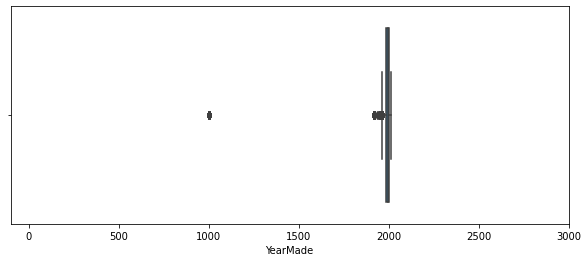

<Figure size 720x288 with 0 Axes>

In [24]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.YearMade)

plt.figure(figsize=(10,4))
plt.xlim(train.Engine_Horsepower.min(), train.Engine_Horsepower.max()*1.1)
sns.boxplot(x=train.item_price)

## Outliers Rule:
1. There are items with strange prices and sales. 
1. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).
1. Remove where item count < 0
1. There is one item with price below zero. Fill it with median.

In [14]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [ ]:
train = train[train.item_cnt_day>0]

In [ ]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

## Remove Duplicates
Several shops are duplicates of each other (according to its name). Fix train and test set.

In [19]:
train[train.shop_id.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [ ]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [ ]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [ ]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

In [ ]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [41]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [39]:
g = train['revenue'].groupby([train['date_block_num'], train['shop_id']])

In [67]:
train[(train.date_block_num == 3) & (train.shop_id == 8)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue


In [46]:
g.mean().unstack()

shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
date_block_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,618.905070,566.933927,1013.132400,748.444606,756.951426,NaN,842.967117,821.100527,686.019438,NaN,659.993143,NaN,1385.946801,209.123377,778.243692,839.886722,725.551705,NaN,1083.645595,776.352712,NaN,599.595866,886.676214,759.543221,871.727858,771.263539,729.013060,1006.991056,824.858607,859.000198,708.493300,750.588779,695.886076,NaN,NaN,738.949469,NaN,720.679161,1142.678075,NaN,NaN,1000.274062,872.560449,1042.084295,580.297778,840.262517,784.025266,945.922597,NaN,NaN,1008.080339,391.383590,703.141212,793.449153,822.991440,NaN,658.246309,NaN,NaN,884.369789
1,724.912717,573.353552,1150.526432,767.929041,844.140496,617.828402,877.050165,848.410268,698.608059,NaN,698.226974,NaN,1605.000820,245.275676,820.701873,856.579642,753.277537,NaN,1119.550201,749.372280,NaN,725.247808,1161.454496,825.112128,928.682500,854.653562,827.589271,997.250464,851.542279,909.083054,707.002633,805.222324,730.809869,NaN,NaN,811.778297,NaN,802.238813,1111.819972,NaN,NaN,1076.479831,986.224700,1167.700422,618.872072,849.714804,875.940251,908.218523,NaN,NaN,964.178788,382.086935,776.072723,827.606098,785.484878,NaN,655.914434,NaN,NaN,816.715802
2,NaN,NaN,1076.284875,715.019123,781.582275,644.939778,959.559842,938.999531,681.931183,NaN,671.296171,NaN,2027.691756,270.887826,837.757557,843.819510,734.224715,NaN,1160.532736,739.754105,NaN,761.228386,1061.255112,880.753951,917.860679,873.603255,1018.585396,1012.896137,864.794268,917.550730,747.968175,847.174176,803.432763,NaN,NaN,855.955138,NaN,806.520172,1149.390551,NaN,NaN,897.060399,1073.590566,1287.863660,650.509213,874.360856,839.264605,869.095775,NaN,NaN,1027.222074,416.188323,723.375789,840.368677,830.020140,NaN,665.713521,775.264946,658.111310,929.775095
3,NaN,NaN,1105.863309,636.414013,791.589844,683.691332,761.686275,672.396030,-599.000000,NaN,527.271817,NaN,1256.027193,253.777661,727.765903,720.011985,648.278377,NaN,1047.831235,686.437140,NaN,647.697959,847.525394,756.864018,829.621813,722.593187,715.063031,852.750149,770.728997,762.575703,614.279661,723.088031,676.410078,NaN,NaN,722.479184,NaN,704.839934,989.987786,NaN,NaN,721.204276,819.347672,941.241379,573.376526,790.216899,733.807927,938.308621,NaN,NaN,882.659441,393.447444,649.875189,716.233529,726.431118,NaN,581.159633,633.416769,604.228703,697.464595
4,NaN,NaN,1021.523540,698.635958,824.220126,593.432547,722.149113,682.538012,NaN,NaN,560.350794,NaN,1676.835489,220.009737,685.506221,730.063372,613.695262,NaN,989.074494,647.528180,NaN,615.116325,857.250665,NaN,902.008276,720.498031,795.088733,793.963479,729.947332,663.522373,610.993818,697.901801,662.364126,NaN,NaN,755.253940,NaN,624.091295,933.766998,NaN,NaN,670.373275,790.949153,856.216848,550.544212,800.657736,706.790144,844.043194,NaN,NaN,846.567147,370.889918,635.561280,730.536774,695.131725,440.677597,585.723553,592.604206,525.466512,684.144054
5,NaN,NaN,1103.125333,714.432692,919.677395,592.778656,819.733098,745.100000,NaN,NaN,637.035242,NaN,2179.500935,245.761789,806.127703,789.489083,659.777199,717.188424,1107.751816,759.247181,NaN,708.514851,1028.739736,NaN,915.331405,788.821691,888.667870,1058.940860,792.491245,804.499318,700.953214,733.559929,767.681021,NaN,NaN,824.455232,NaN,732.404114,1006.613127,NaN,NaN,838.693296,1009.156348,1146.903638,657.725627,870.887782,770.325901,839.382131,NaN,NaN,1011.054859,413.435225,725.130435,805.259912,723.171489,427.478503,621.498081,643.238720,614.535880,816.002048
6,NaN,NaN,1124.833333,811.422156,748.979279,560.879528,711.163018,725.607422,NaN,NaN,533.134048,NaN,1369.985543,223.461765,671.304622,640.807936,642.587653,597.054545,1000.661214,652.241581,NaN,568.682731,860.815835,NaN,905.318820,671.821534,710.675935,741.332569,731.613393,770.546009,585.896584,647.249669,594.943820,NaN,NaN,714.968272

In [20]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [23]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})


AttributeError: 'DataFrame' object has no attribute 'shop_id'

In [24]:
group

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0
...                                     ...
33             59      22087            6.0
                       22088            2.0
                       22091            1.0
                       22100            1.0
                       22102            1.0

[1609123 rows x 1 columns]

In [ ]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

# Data preparation for modeling

## Convert dependent variable to log?

In [49]:
# Note: for this competition there are 2 rules
# 1. use log + 1 for dependent variable
# 2. remove < 0 samples (they are returns, but they should not be used to model)
# numpy.clip(df, 0, None) converts values <0 to 0 and has no maximum value
train.unit_sales = np.log1p(np.clip(train.unit_sales, 0, None))
# train.unit_sales = np.log(train.unit_sales)

## Add date column features

In [60]:
for date_column in date_columns:
    add_datepart(train, date_column)

## Order by date

In [44]:
if not train.date.is_monotonic:
    print('Sorting by date column')
    train.sort_values(by='date')
else:
    print('Already sorted by date')

Already sorted by date


# Test set
To use time tricks append test pairs to the matrix.

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [ ]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

# Save train/valid/test datasets to feather for fast model iteration

In [71]:
if not os.path.isdir(feather_dir):
    os.makedirs(feather_dir, mode=0o7777)
train.to_feather(os.path.join(feather_dir, 'train.feather'))

## Shops/Items/Cats features

In [ ]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

## Traget lags

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

## Mean encoded features

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

## Trend features

Price trend for the last six months.

In [ ]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

Last month shop revenue trend

In [ ]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

## Special features

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [ ]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [ ]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

In [ ]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

Months since the first sale for each shop/item pair and for item only.

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

Producing lags brings a lot of nulls.

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.columns

In [ ]:
matrix.info()

In [ ]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Prepare FastAi Tabular Data Loaders

## FastAi Tabular Data Loaders Parameters

In [ ]:
cont_cols, cat_cols = cont_cat_split(df)

# cont_cols=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99']
# cat_cols = []
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
dep_var = 'unit_sales'
batch_size = 64
batch_size=1024


In [ ]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                       cat_names=cat_cols,
                       cont_names=cont_cols,
                       y_names=dep_var,
                       splits=splits)
dls = to.dataloaders(bs=batch_size)

In [ ]:
X_train = dls.train.xs
y_train = dls.train.y.ravel()

In [ ]:
# Possible optimization of data type conversions, convert to np array
X_train = np.array(X, dtype=np.float32)

# Modeling

# Random Forest

## Train

## Plot Feature Importances

## Plot high feature importance columns against dep var

# Xgboost

In [ ]:
data = pd.read_pickle('data.pkl')

Select perfect features

In [ ]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
del data
gc.collect();

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
plot_features(model, (10,14))